<a href="https://colab.research.google.com/github/irojasga0721/Proyecto-de-grado/blob/main/Proyecto_de_grado_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Paso 1: Instalación de librerías necesarias
!pip install statsmodels --quiet
!pip install pmdarima --quiet
!pip install xgboost --quiet

# Paso 2: Importación de todas las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Para series temporales
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Para machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Para optimización de ARIMA
import pmdarima as pm

print("✅ Todas las librerías importadas correctamente")

✅ Todas las librerías importadas correctamente


In [ ]:
import gdown
import pandas as pd
import os

# --- ID del archivo (Construido del enlace) ---
file_id = '13dLjgz5DFGhE1kQBffC0_b0DNcolMQYu'
output_filename = 'base_precipitacion_demanda_final_limpia.csv'
# ---------------------------------------------

# 2. Descargamos el archivo de Google Drive
# Asegúrate de que los permisos de tu archivo de Drive estén en "Cualquier persona con el enlace"
print(f"Descargando el archivo: {output_filename}...")
gdown.download(id=file_id, output=output_filename, quiet=False)

# 3. Cargamos el archivo CSV descargado en un DataFrame de pandas
if os.path.exists(output_filename):
    df = pd.read_csv(output_filename)
    print("\n¡Archivo cargado exitosamente!")
    print(f"Forma del DataFrame: {df.shape}")
    print("\nPrimeras 5 filas del archivo:")
    print(df.head())
    print(df.info())


else:
    print("\nError: No se pudo descargar el archivo. Asegúrate de que el ID es correcto y que el archivo tiene permisos de acceso público.")

Descargando el archivo: base_precipitacion_demanda_final_limpia.csv...


Downloading...
From: https://drive.google.com/uc?id=13dLjgz5DFGhE1kQBffC0_b0DNcolMQYu
To: /content/base_precipitacion_demanda_final_limpia.csv
100%|██████████| 10.0k/10.0k [00:00<00:00, 13.3MB/s]


¡Archivo cargado exitosamente!
Forma del DataFrame: (168, 6)

Primeras 5 filas del archivo:
      Año  Mes  SumaPrecipitacion_mm  Demanda_Energia_SIN_kWh  Generación_kWh  \
0  2010.0  1.0                1747.2             4.576941e+09    4.617623e+09   
1  2010.0  2.0                4212.2             4.409460e+09    4.410514e+09   
2  2010.0  3.0               10779.6             4.890121e+09    4.887825e+09   
3  2010.0  4.0               12311.9             4.610755e+09    4.607225e+09   
4  2010.0  5.0               10861.4             4.785909e+09    4.781791e+09   

   Demanda_No_Atendida_kWh  
0                2429210.0  
1                2598730.0  
2                6706580.0  
3                3219540.0  
4                4186230.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Año                      168 

In [ ]:
# Definición de la variable objetivo
target = 'Demanda_Energia_SIN_kWh'

# Lag del mes anterior (t-1)
df['Demanda_Lag_1'] = df[target].shift(1)

# Lag estacional del mismo mes del año anterior (t-12)
df['Demanda_Lag_12'] = df[target].shift(12)

# --- Paso Faltante: Añadir la variable Trimestre ---
# Asumiendo que el índice es un DatetimeIndex (lo cual es necesario para extraer el trimestre)
df['Trimestre'] = df.index.quarter
# Ahora puedes usar df.dropna() y luego asignarlo a df_model

df_model = df.dropna()

# Eliminamos las filas con valores faltantes (NaN) generadas por la operación shift
# Dado que usamos un lag de 12, se eliminarán las primeras 12 filas.
df_model = df.dropna()

print("\n--- DataFrame con Lags (primeras filas sin NaNs) ---")
print(df_model.head())
print(f"\nForma del DataFrame final (listo para modelar): {df_model.shape}")


--- DataFrame con Lags (primeras filas sin NaNs) ---
             Año  Mes  SumaPrecipitacion_mm  Demanda_Energia_SIN_kWh  \
2011-01-01  2011    1                3821.6             4.666630e+09   
2011-02-01  2011    2                6001.5             4.359000e+09   
2011-03-01  2011    3                8691.5             4.801205e+09   
2011-04-01  2011    4               14090.3             4.587453e+09   
2011-05-01  2011    5               11731.7             4.855477e+09   

            Generación_kWh  Demanda_No_Atendida_kWh  Demanda_Lag_1  \
2011-01-01    4.842566e+09                3904770.0   4.707232e+09   
2011-02-01    4.480266e+09                4942500.0   4.666630e+09   
2011-03-01    5.052470e+09                5948560.0   4.359000e+09   
2011-04-01    4.681036e+09                9749280.0   4.801205e+09   
2011-05-01    4.922134e+09                3529520.0   4.587453e+09   

            Demanda_Lag_12  Trimestre  
2011-01-01    4.576941e+09          1  
2011-02-01  

In [ ]:
# Definimos el tamaño del conjunto de prueba (últimos 2 años = 24 meses)
test_size = 24
train_df = df_model.iloc[:-test_size]
test_df = df_model.iloc[-test_size:]

print(f"\nFecha de inicio del entrenamiento: {train_df.index.min()}")
print(f"Fecha de fin del entrenamiento: {train_df.index.max()}")
print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print("-" * 40)
print(f"Fecha de inicio de la prueba: {test_df.index.min()}")
print(f"Fecha de fin de la prueba: {test_df.index.max()}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")

# Definición de X (Features) e Y (Target) para Machine Learning
FEATURES_ML = ['Mes','Trimestre', 'Año', 'Demanda_Lag_1', 'Demanda_Lag_12',
               'SumaPrecipitacion_mm', 'Generación_kWh', 'Demanda_No_Atendida_kWh']
TARGET = target # Demanda_Energia_SIN_kWh

X_train = train_df[FEATURES_ML]
y_train = train_df[TARGET]
X_test = test_df[FEATURES_ML]
y_test = test_df[TARGET]


Fecha de inicio del entrenamiento: 2011-01-01 00:00:00
Fecha de fin del entrenamiento: 2021-12-01 00:00:00
Tamaño del conjunto de entrenamiento: 132
----------------------------------------
Fecha de inicio de la prueba: 2022-01-01 00:00:00
Fecha de fin de la prueba: 2023-12-01 00:00:00
Tamaño del conjunto de prueba: 24


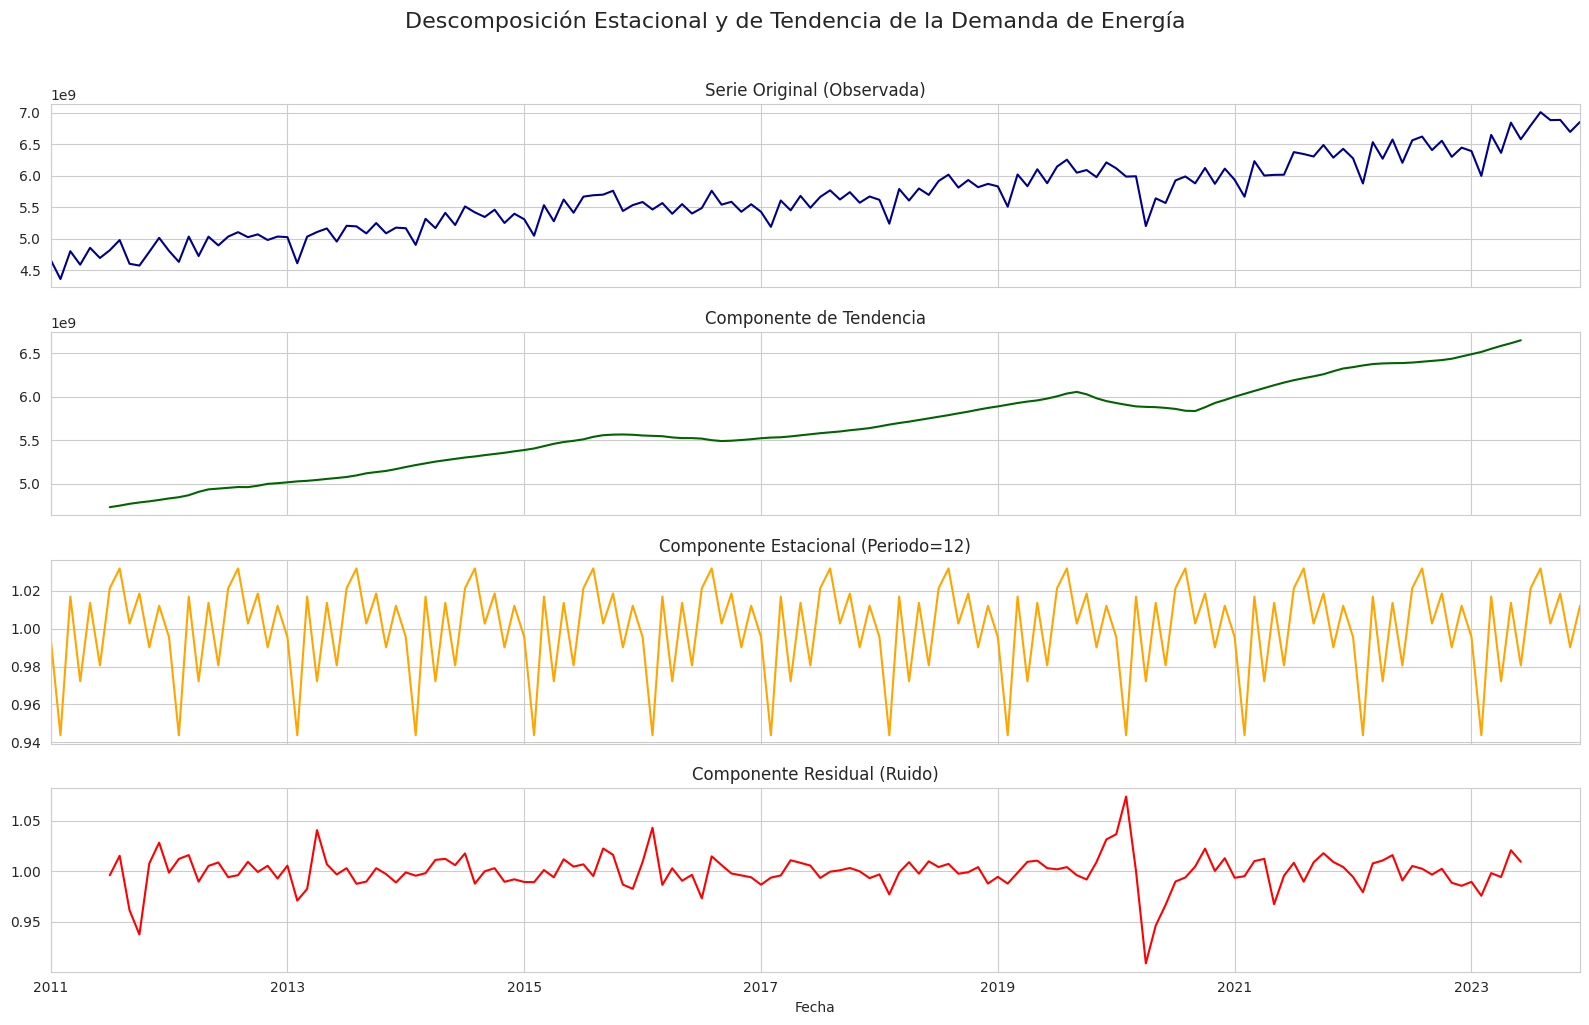

In [ ]:
# Se utiliza la función seasonal_decompose de statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. Descomposición de la serie de Demanda (Tendencia y Estacionalidad)
# Se usa 'multiplicative' porque la magnitud de las variaciones estacionales parece crecer con la tendencia.
# Se asume que 'df_model' es tu DataFrame con la columna de Demanda y el índice de tiempo configurado.
result = seasonal_decompose(
    df_model['Demanda_Energia_SIN_kWh'],
    model='multiplicative',
    period=12 # 12 para la estacionalidad mensual
)

# 2. Visualización de los componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10), sharex=True)

result.observed.plot(ax=ax1, title='Serie Original (Observada)', color='darkblue')
result.trend.plot(ax=ax2, title='Componente de Tendencia', color='darkgreen')
result.seasonal.plot(ax=ax3, title='Componente Estacional (Periodo=12)', color='orange')
result.resid.plot(ax=ax4, title='Componente Residual (Ruido)', color='red')

plt.xlabel('Fecha')
plt.suptitle('Descomposición Estacional y de Tendencia de la Demanda de Energía', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()


--- Matriz de Correlación de Pearson ---
                         Demanda_Energia_SIN_kWh  SumaPrecipitacion_mm  \
Demanda_Energia_SIN_kWh                 1.000000              0.341990   
SumaPrecipitacion_mm                    0.341990              1.000000   
Generación_kWh                          0.984093              0.258935   
Demanda_No_Atendida_kWh                 0.053955              0.008111   

                         Generación_kWh  Demanda_No_Atendida_kWh  
Demanda_Energia_SIN_kWh        0.984093                 0.053955  
SumaPrecipitacion_mm           0.258935                 0.008111  
Generación_kWh                 1.000000                 0.051419  
Demanda_No_Atendida_kWh        0.051419                 1.000000  


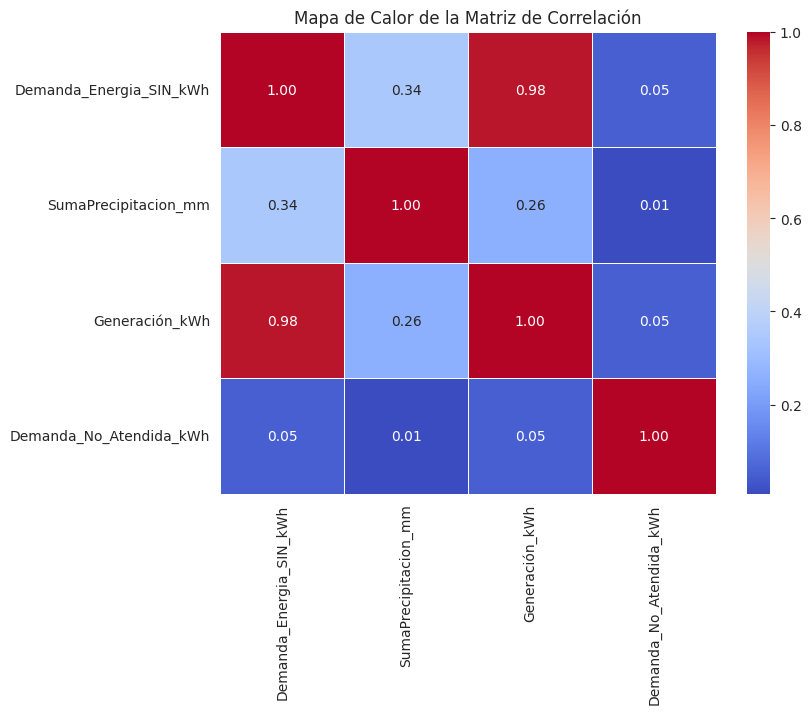

In [ ]:
# Analizando la correlación de Pearson entre las variables
correlation_matrix = df[['Demanda_Energia_SIN_kWh', 'SumaPrecipitacion_mm', 'Generación_kWh', 'Demanda_No_Atendida_kWh']].corr()

print("\n--- Matriz de Correlación de Pearson ---")
print(correlation_matrix)

# Visualización con un mapa de calor (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

--- 1. CCF: Demanda de Energía vs. Precipitación ---


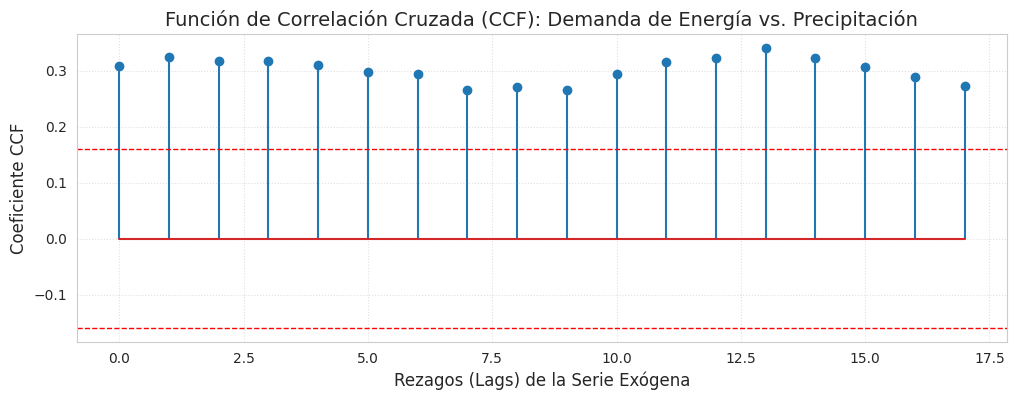


--- 2. CCF: Demanda de Energía vs. Demanda No Atendida ---


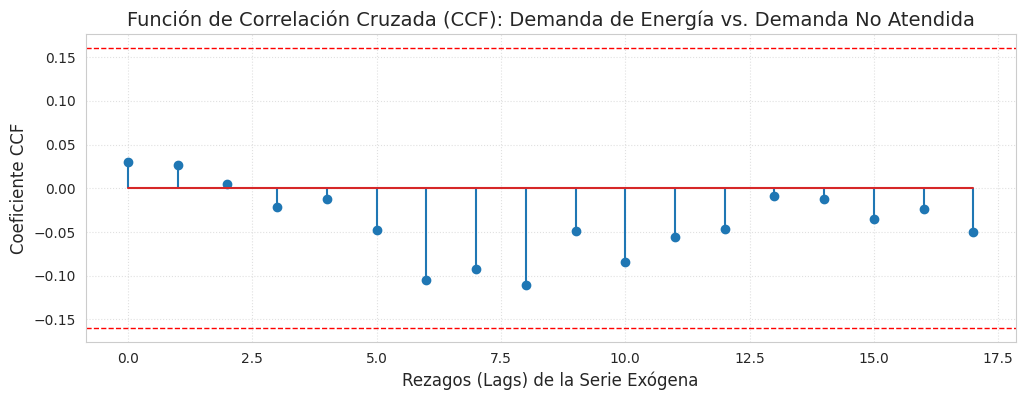

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf
import numpy as np
import pandas as pd

# Asumiendo que df_model existe y tiene las columnas requeridas
# 1. Correlación entre Demanda y Precipitación
ccf_demand_precip = ccf(df_model['Demanda_Energia_SIN_kWh'], df_model['SumaPrecipitacion_mm'], adjusted=False)

# 2. Correlación entre Demanda y Demanda No Atendida
ccf_demand_no_atendida = ccf(df_model['Demanda_Energia_SIN_kWh'], df_model['Demanda_No_Atendida_kWh'], adjusted=False)

# 3. Función de Gráfica (CORREGIDA)
def plot_ccf(series1_name, series2_name, ccf_values, num_lags=24):
    """Función para graficar la CCF con la corrección de Matplotlib."""
    plt.figure(figsize=(12, 4))

    # --- CORRECCIÓN: Se elimina el argumento 'use_line_collection=True' ---
    plt.stem(range(num_lags), ccf_values[:num_lags])
    # -----------------------------------------------------------------------

    plt.title(f'Función de Correlación Cruzada (CCF): {series1_name} vs. {series2_name}', fontsize=14)
    plt.xlabel('Rezagos (Lags) de la Serie Exógena', fontsize=12)
    plt.ylabel('Coeficiente CCF', fontsize=12)

    # Añadir las bandas de significancia (aproximadamente 2/sqrt(N))
    # N es el tamaño de los datos de modelado (df_model)
    banda_sig = 2 / np.sqrt(len(df_model))
    plt.axhline(y=banda_sig, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=-banda_sig, color='red', linestyle='--', linewidth=1)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# 4. Ejecutar las gráficas (para los primeros 24 meses)
print("--- 1. CCF: Demanda de Energía vs. Precipitación ---")
plot_ccf('Demanda de Energía', 'Precipitación', ccf_demand_precip, num_lags=18)

print("\n--- 2. CCF: Demanda de Energía vs. Demanda No Atendida ---")
plot_ccf('Demanda de Energía', 'Demanda No Atendida', ccf_demand_no_atendida, num_lags=18)

In [ ]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller

# 1. Ajustar el modelo de regresión
ols_model = OLS(df_model['Generación_kWh'], df_model['Demanda_Energia_SIN_kWh']).fit()

# 2. Extraer los residuos (errores)
residuals = ols_model.resid

# 3. Aplicar la prueba ADF a los residuos (prueba de cointegración)
adf_result = adfuller(residuals, autolag='AIC')
p_value_adf = adf_result[1]

print("\n--- Prueba de Cointegración (Residuos de Generación vs. Demanda) ---")
print(f'Valor p (ADF de los residuos): {p_value_adf:.4f}')

if p_value_adf <= 0.05:
    print("\nConclusión: Se rechaza H0. Las series están COINTEGRADAS (se mueven juntas).")
    print("IMPLICACIÓN: Incluir Generación como exógena es REDUNDANTE. Se recomienda eliminar Generación_kWh o la Demanda_No_Atendida_kWh (la menos significativa) para el pronóstico final, o usar solo Generación si es más significativa que Demanda_No_Atendida.")
else:
    print("\nConclusión: NO se rechaza H0. Las series NO están cointegradas.")


--- Prueba de Cointegración (Residuos de Generación vs. Demanda) ---
Valor p (ADF de los residuos): 0.0618

Conclusión: NO se rechaza H0. Las series NO están cointegradas.


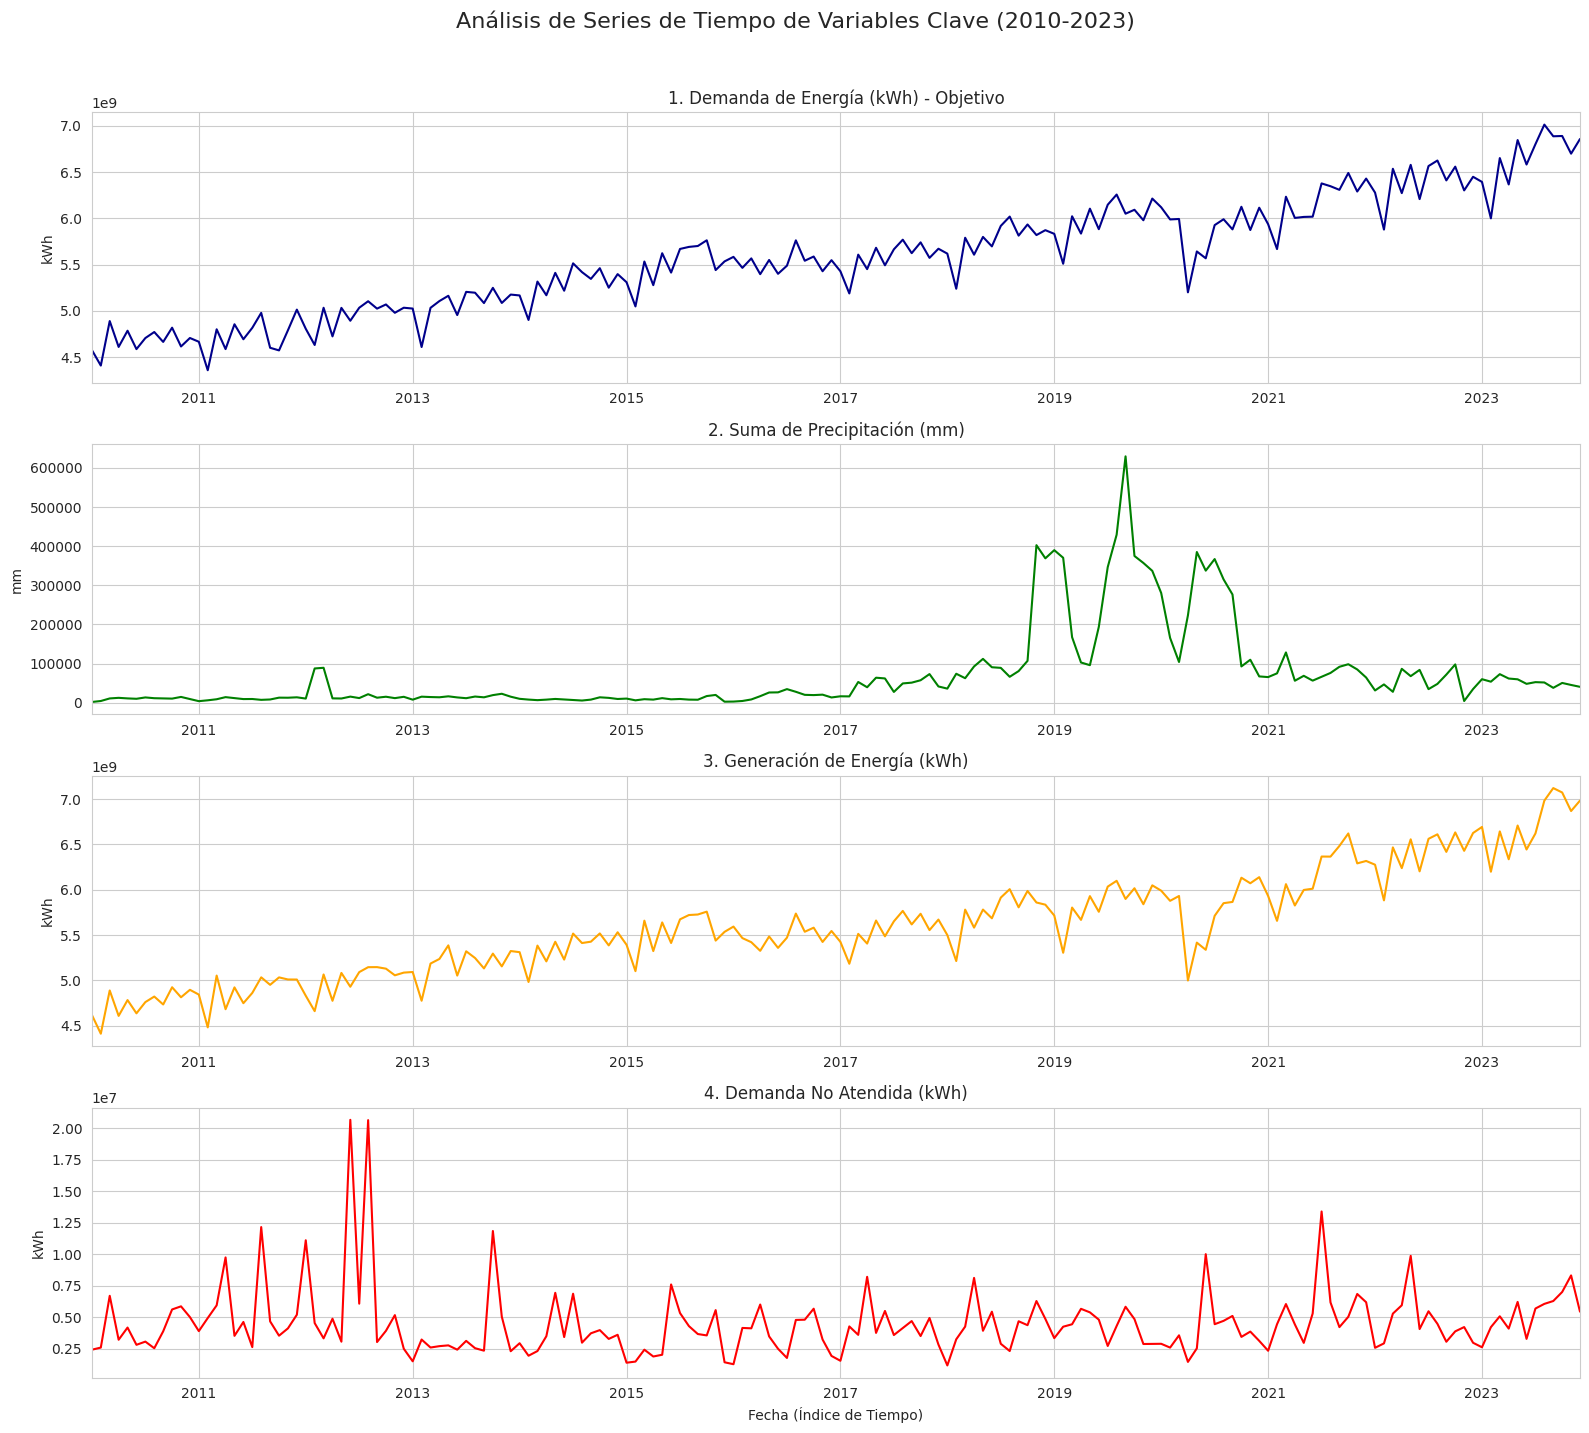

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Código Corregido e Integrado para las 4 Series de Tiempo ---

# Configuración de Matplotlib/Seaborn para mejores gráficos
sns.set_style("whitegrid")

# Crear una figura con 4 subplots apilados (4 filas, 1 columna)
plt.figure(figsize=(16, 14))

# 1. Demanda de Energía (Variable Objetivo)
plt.subplot(4, 1, 1)
df['Demanda_Energia_SIN_kWh'].plot(title='1. Demanda de Energía (kWh) - Objetivo', color='darkblue', linewidth=1.5)
plt.ylabel('kWh')
plt.xlabel('') # Dejar el eje x vacío para evitar redundancia

# 2. Suma de Precipitación (Variable Exógena)
plt.subplot(4, 1, 2)
df['SumaPrecipitacion_mm'].plot(title='2. Suma de Precipitación (mm)', color='green', linewidth=1.5)
plt.ylabel('mm')
plt.xlabel('')

# 3. Generación de Energía (Variable Exógena / Correlación alta)
plt.subplot(4, 1, 3)
df['Generación_kWh'].plot(title='3. Generación de Energía (kWh)', color='orange', linewidth=1.5)
plt.ylabel('kWh')
plt.xlabel('')

# 4. Demanda No Atendida (Variable Exógena / Volátil)
plt.subplot(4, 1, 4)
df['Demanda_No_Atendida_kWh'].plot(title='4. Demanda No Atendida (kWh)', color='red', linewidth=1.5)
plt.ylabel('kWh')
plt.xlabel('Fecha (Índice de Tiempo)') # Solo mostrar la etiqueta de fecha al final

plt.suptitle('Análisis de Series de Tiempo de Variables Clave (2010-2023)', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 1.0]) # Ajustar el diseño para que no se superpongan
plt.show()

In [ ]:
import pmdarima as pm

# 1. Definición de la variable objetivo y las variables exógenas (exógenas para SARIMAX)
# Nota: SARIMAX modela el target (Demanda) y usa las exógenas como variables de soporte.
# Aquí NO incluimos los Lags de la propia demanda (Lag_1, Lag_12) ni el 'Año',
# ya que SARIMAX maneja la autoregresión (p, q) y la tendencia/estacionalidad (d, P, Q, S) internamente.

FEATURES_SARIMAX = ['SumaPrecipitacion_mm', 'Generación_kWh', 'Demanda_No_Atendida_kWh']

# Creamos los conjuntos de datos de entrenamiento para SARIMAX
y_train_sarimax = train_df[TARGET]
X_train_sarimax = train_df[FEATURES_SARIMAX]
X_test_sarimax = test_df[FEATURES_SARIMAX]


print("\n--- Búsqueda Automática de Órdenes SARIMAX (Auto ARIMA) ---")
# Usamos un enfoque de búsqueda por paso (stepwise) para encontrar los mejores órdenes (p, d, q) y (P, D, Q)
# Se establece m=12 para la frecuencia mensual (estacionalidad).

modelo_sarimax = pm.auto_arima(
    y_train_sarimax,
    X=X_train_sarimax, # Variables exógenas
    start_p=1, start_q=1,
    test='adf', # Usamos la prueba ADF para determinar 'd'
    max_p=3, max_q=3,
    m=12, # Estacionalidad de 12 meses
    start_P=0, seasonal=True, # Habilitar búsqueda estacional
    d=None, D=None, # Dejar que auto_arima encuentre d y D óptimos
    trace=True, # Mostrar el proceso de búsqueda
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1 # Usar todos los núcleos para acelerar
)

print("\n--- Resumen del Modelo SARIMAX Seleccionado ---")
print(modelo_sarimax.summary())

# Guardar los parámetros óptimos
sarimax_order = modelo_sarimax.order
sarimax_seasonal_order = modelo_sarimax.seasonal_order
print(f"\nÓrdenes óptimas: {sarimax_order} x {sarimax_seasonal_order}")

# 2. Generar Pronóstico en el Conjunto de Prueba
# Usamos los valores de las variables exógenas (X_test_sarimax) para predecir Y
forecast_sarimax = modelo_sarimax.predict(
    n_periods=len(X_test_sarimax),
    X=X_test_sarimax # Las variables exógenas del conjunto de prueba
)

# Creamos un DataFrame para comparar resultados
df_results = pd.DataFrame({'SARIMAX_Forecast': forecast_sarimax.values}, index=y_test.index)
df_results['Actual'] = y_test.values

print("\n--- Pronóstico SARIMAX en Conjunto de Prueba (Primeras 5) ---")
print(df_results.head())


--- Búsqueda Automática de Órdenes SARIMAX (Auto ARIMA) ---
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=5150.534, Time=3.22 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5222.126, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5150.649, Time=2.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5164.308, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5733.728, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=5149.848, Time=0.82 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=5149.935, Time=0.86 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=5149.257, Time=3.25 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=5149.798, Time=2.43 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=5149.951, Time=2.38 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=5148.698, Time=1.82 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=5158.163, Time=1.62 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5150.058, Time=1.29 sec
 ARIMA(2,0,1)(0,0,2)[12] 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("\n--- Entrenamiento de Random Forest Regressor ---")

# Inicializar y entrenar el modelo Random Forest
# Usamos parámetros iniciales robustos
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Generar Pronóstico en el Conjunto de Prueba
forecast_rf = rf_model.predict(X_test)

# Añadir resultados al DataFrame de resultados
df_results['RF_Forecast'] = forecast_rf

print("\n--- Pronóstico Random Forest en Conjunto de Prueba (Primeras 5) ---")
print(df_results.head())


--- Entrenamiento de Random Forest Regressor ---

--- Pronóstico Random Forest en Conjunto de Prueba (Primeras 5) ---
            SARIMAX_Forecast        Actual   RF_Forecast
2022-01-01      6.318905e+09  6.277908e+09  6.299006e+09
2022-02-01      5.901748e+09  5.878352e+09  6.015809e+09
2022-03-01      6.464189e+09  6.535305e+09  6.342037e+09
2022-04-01      6.279893e+09  6.272358e+09  6.297986e+09
2022-05-01      6.549904e+09  6.577625e+09  6.364248e+09


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

print("\n--- Entrenamiento de Gradient Boosting Regressor ---")

# Inicializar y entrenar el modelo Gradient Boosting
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)

# Generar Pronóstico en el Conjunto de Prueba
forecast_gbr = gbr_model.predict(X_test)

# Añadir resultados al DataFrame de resultados
df_results['GBR_Forecast'] = forecast_gbr

print("\n--- Pronóstico Gradient Boosting en Conjunto de Prueba (Primeras 5) ---")
print(df_results.head())


--- Entrenamiento de Gradient Boosting Regressor ---

--- Pronóstico Gradient Boosting en Conjunto de Prueba (Primeras 5) ---
            SARIMAX_Forecast        Actual   RF_Forecast  GBR_Forecast
2022-01-01      6.318905e+09  6.277908e+09  6.299006e+09  6.239988e+09
2022-02-01      5.901748e+09  5.878352e+09  6.015809e+09  6.002527e+09
2022-03-01      6.464189e+09  6.535305e+09  6.342037e+09  6.355858e+09
2022-04-01      6.279893e+09  6.272358e+09  6.297986e+09  6.321519e+09
2022-05-01      6.549904e+09  6.577625e+09  6.364248e+09  6.458591e+09


In [ ]:
# 1. Definir todo el conjunto de datos df_model para el reentrenamiento
y_full = df_model[TARGET]
X_full = df_model[FEATURES_SARIMAX] # Solo las variables exógenas

print("Reentrenando el modelo SARIMAX con todos los datos disponibles...")

# Ajustar el modelo con los órdenes óptimos encontrados
from statsmodels.tsa.statespace.sarimax import SARIMAX

final_sarimax_model = SARIMAX(
    y_full,
    exog=X_full,
    order=(1, 0, 1),
    seasonal_order=(0, 0, 2, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_sarimax_results = final_sarimax_model.fit(disp=False)

Reentrenando el modelo SARIMAX con todos los datos disponibles...


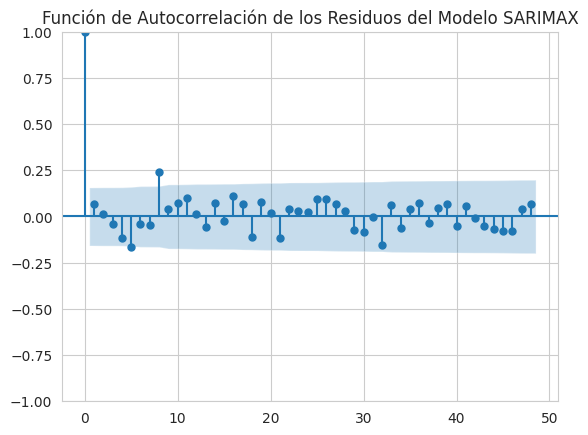

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Asumiendo que 'results_sarimax' es el objeto que contiene el modelo SARIMAX ajustado
# Se extraen los residuos y se grafica su ACF.
plot_acf(
    final_sarimax_results.resid,
    lags=48, # Se suelen graficar varios lags, 48 es común para series mensuales
    title='Función de Autocorrelación de los Residuos del Modelo SARIMAX'
)
plt.show()

In [ ]:
# Se ejecuta la prueba de Ljung-Box (tipo 'Ljung-Box') sobre los residuos del modelo
ljung_box_results = final_sarimax_results.test_serial_correlation(method='ljungbox')

# El resultado es una tabla donde el valor 'pvalue' debe ser > 0.05
print(ljung_box_results)

[[[1.50340887e-02 5.06119525e-01 5.62132643e-01 5.37121687e+00
   1.34854794e+01 1.54943516e+01 1.81034123e+01 2.66127213e+01
   2.69729796e+01 2.76068454e+01 3.01917223e+01 3.02197231e+01
   3.15031970e+01 3.34185440e+01 3.36546448e+01 3.50289769e+01
   3.58110553e+01 4.17762674e+01 4.21138580e+01 4.24618975e+01
   4.77131120e+01 4.77477536e+01 4.80175045e+01 4.87482173e+01]
  [9.02413105e-01 7.76421479e-01 9.05043816e-01 2.51283672e-01
   1.92301534e-02 1.67413057e-02 1.15120375e-02 8.24458922e-04
   1.41323489e-03 2.08611465e-03 1.47835809e-03 2.58737093e-03
   2.84453759e-03 2.50624077e-03 3.80653518e-03 3.93817105e-03
   4.86025979e-03 1.18827950e-03 1.71072376e-03 2.40655636e-03
   7.52245364e-04 1.17132228e-03 1.66447175e-03 2.03698784e-03]]]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Asumiendo que df_results contiene las columnas 'Actual', 'SARIMAX_Forecast', 'RF_Forecast', 'GBR_Forecast'

def calculate_metrics(y_true, y_pred, model_name):
    """Calcula y devuelve MAE, RMSE, R2, y MAPE."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    # Cálculo de MAPE (Mean Absolute Percentage Error)
    # Se añade un pequeño epsilon para evitar división por cero si hubiera valores muy cercanos a cero,
    # aunque en este caso la Demanda es alta.
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'Modelo': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE (%)': mape
    }

# 1. Definir los valores reales
y_test = df_results['Actual']

# 2. Calcular las métricas para cada modelo
metrics_sarimax = calculate_metrics(y_test, df_results['SARIMAX_Forecast'], 'SARIMAX (1,0,1)x(0,0,2,12)')
metrics_rf = calculate_metrics(y_test, df_results['RF_Forecast'], 'Random Forest')
metrics_gbr = calculate_metrics(y_test, df_results['GBR_Forecast'], 'Gradient Boosting')

# 3. Consolidar los resultados en un DataFrame
results_df = pd.DataFrame([metrics_sarimax, metrics_rf, metrics_gbr])
results_df = results_df.set_index('Modelo')

# Formatear la salida para facilitar la lectura
results_df['MAE'] = results_df['MAE'].apply(lambda x: f'{x:,.0f}')
results_df['RMSE'] = results_df['RMSE'].apply(lambda x: f'{x:,.0f}')
results_df['R2'] = results_df['R2'].apply(lambda x: f'{x:.4f}')
results_df['MAPE (%)'] = results_df['MAPE (%)'].apply(lambda x: f'{x:.2f}%')

print("\n--- Tabla Comparativa de Rendimiento (Conjunto de Prueba 2022-2023) ---")
print("Criterio: Menor MAE/RMSE/MAPE y Mayor R2 es Mejor.")
print(results_df)


--- Tabla Comparativa de Rendimiento (Conjunto de Prueba 2022-2023) ---
Criterio: Menor MAE/RMSE/MAPE y Mayor R2 es Mejor.
                                    MAE         RMSE       R2 MAPE (%)
Modelo                                                                
SARIMAX (1,0,1)x(0,0,2,12)   90,260,969  117,114,998   0.8255    1.37%
Random Forest               229,431,539  286,660,822  -0.0457    3.43%
Gradient Boosting           203,657,361  266,539,433   0.0959    3.04%


In [ ]:
# 2. Crear el índice de fechas futuras
future_start_date = df_model.index.max() + pd.DateOffset(months=1)
future_end_date = '2030-12-01'
future_dates = pd.date_range(start=future_start_date, end=future_end_date, freq='MS')

# Crear el DataFrame futuro
df_future = pd.DataFrame(index=future_dates)
df_future['SumaPrecipitacion_mm'] = 0.0
df_future['Generación_kWh'] = 0.0
df_future['Demanda_No_Atendida_kWh'] = 0.0

# 3. CRÍTICO: Rellenar las variables exógenas futuras
# Aquí es donde necesitas tomar una decisión de modelado (Opción Robusta).
# *** PARA FINES DE LA PRÁCTICA, USAREMOS UNA PROYECCIÓN SIMPLE DE TENDENCIA PARA 'Generación_kWh' Y MEDIA PARA LAS OTRAS. ***

# Proyección de Generación_kWh (Asumiendo crecimiento lineal o de tendencia)
# Una aproximación simple es la media de los últimos 12 meses + un factor de tendencia:
last_12_gen_mean = df_model['Generación_kWh'].iloc[-12:].mean()
# Para simular la tendencia creciente (ajusta este valor si tienes una hipótesis de crecimiento anual)
trend_factor = 1.005 # 0.5% de crecimiento mensual
df_future['Generación_kWh'] = last_12_gen_mean * (trend_factor ** np.arange(1, len(df_future) + 1))

# Proyección de Precipitación y Demanda No Atendida (Asumiendo media histórica ya que son volátiles/no significativas en SARIMAX)
df_future['SumaPrecipitacion_mm'] = df_model['SumaPrecipitacion_mm'].mean()
df_future['Demanda_No_Atendida_kWh'] = df_model['Demanda_No_Atendida_kWh'].mean()

print("\n--- Primeras 5 Filas del DataFrame de Features Futuras ---")
print(df_future.head())


--- Primeras 5 Filas del DataFrame de Features Futuras ---
            SumaPrecipitacion_mm  Generación_kWh  Demanda_No_Atendida_kWh
2024-01-01          76232.015891    6.757305e+09             4.581957e+06
2024-02-01          76232.015891    6.791091e+09             4.581957e+06
2024-03-01          76232.015891    6.825047e+09             4.581957e+06
2024-04-01          76232.015891    6.859172e+09             4.581957e+06
2024-05-01          76232.015891    6.893468e+09             4.581957e+06


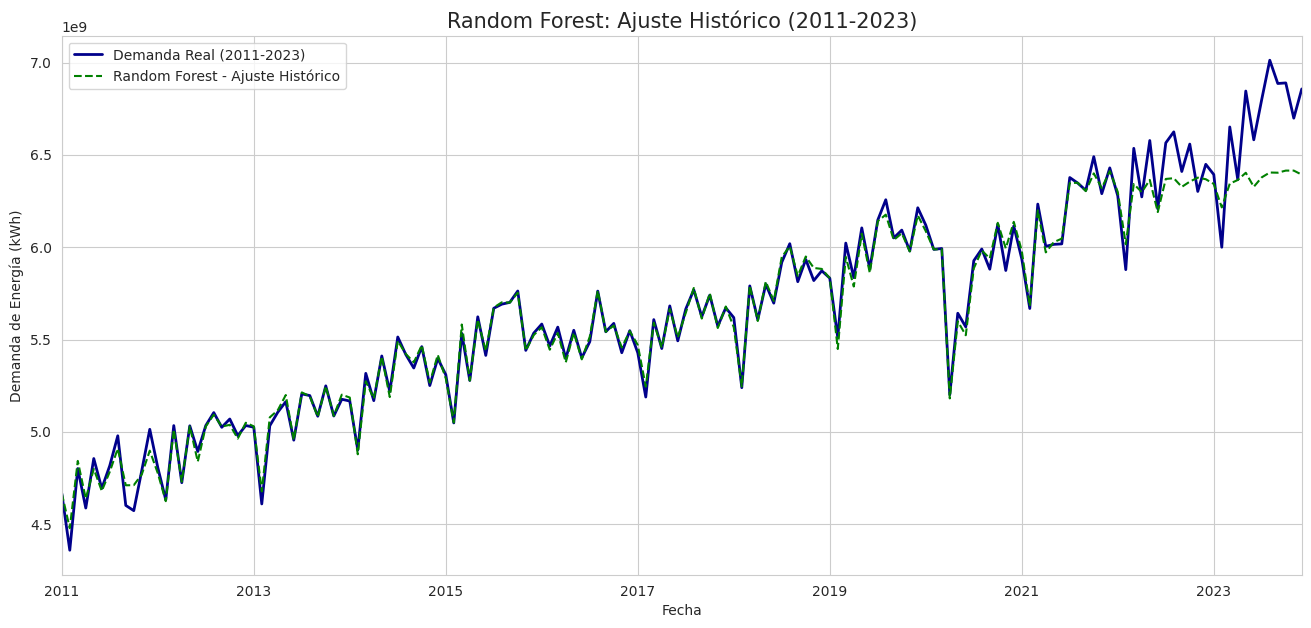

In [ ]:
# Random Forest fue entrenado con X_train y y_train, pero para el ajuste histórico
# lo evaluaremos sobre todo el X_full (con los lags)
rf_full_prediction = rf_model.predict(df_model[FEATURES_ML])
rf_full_prediction_series = pd.Series(rf_full_prediction, index=df_model.index, name='RF - Ajuste Histórico')

plt.figure(figsize=(16, 7))
plt.title('Random Forest: Ajuste Histórico (2011-2023)', fontsize=15)

# Trazar la Demanda Real
y_full.plot(label='Demanda Real (2011-2023)', color='darkblue', linewidth=2)

# Trazar el ajuste del modelo RF
rf_full_prediction_series.plot(label='Random Forest - Ajuste Histórico', color='green', linestyle='--', linewidth=1.5)

plt.xlabel('Fecha')
plt.ylabel('Demanda de Energía (kWh)')
plt.legend()
plt.grid(True)
plt.show()

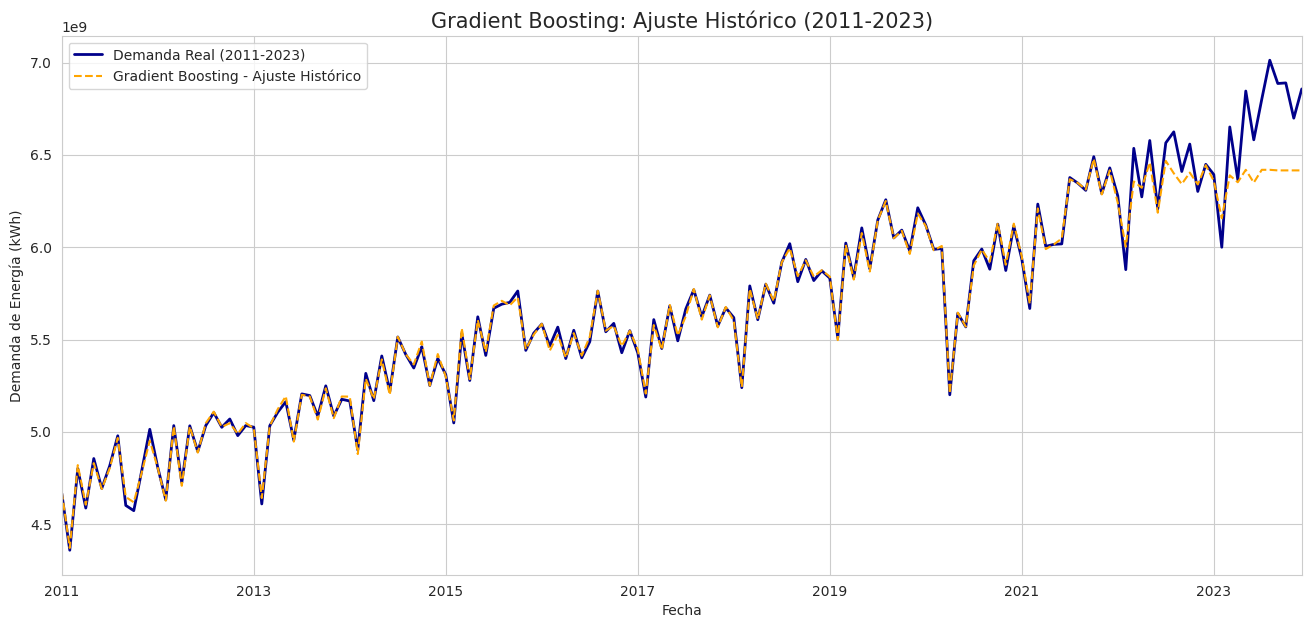

In [ ]:
# Gradient Boosting (GBR) fue entrenado con X_train y y_train
gbr_full_prediction = gbr_model.predict(df_model[FEATURES_ML])
gbr_full_prediction_series = pd.Series(gbr_full_prediction, index=df_model.index, name='GBR - Ajuste Histórico')

plt.figure(figsize=(16, 7))
plt.title('Gradient Boosting: Ajuste Histórico (2011-2023)', fontsize=15)

# Trazar la Demanda Real
y_full.plot(label='Demanda Real (2011-2023)', color='darkblue', linewidth=2)

# Trazar el ajuste del modelo GBR
gbr_full_prediction_series.plot(label='Gradient Boosting - Ajuste Histórico', color='orange', linestyle='--', linewidth=1.5)

plt.xlabel('Fecha')
plt.ylabel('Demanda de Energía (kWh)')
plt.legend()
plt.grid(True)
plt.show()

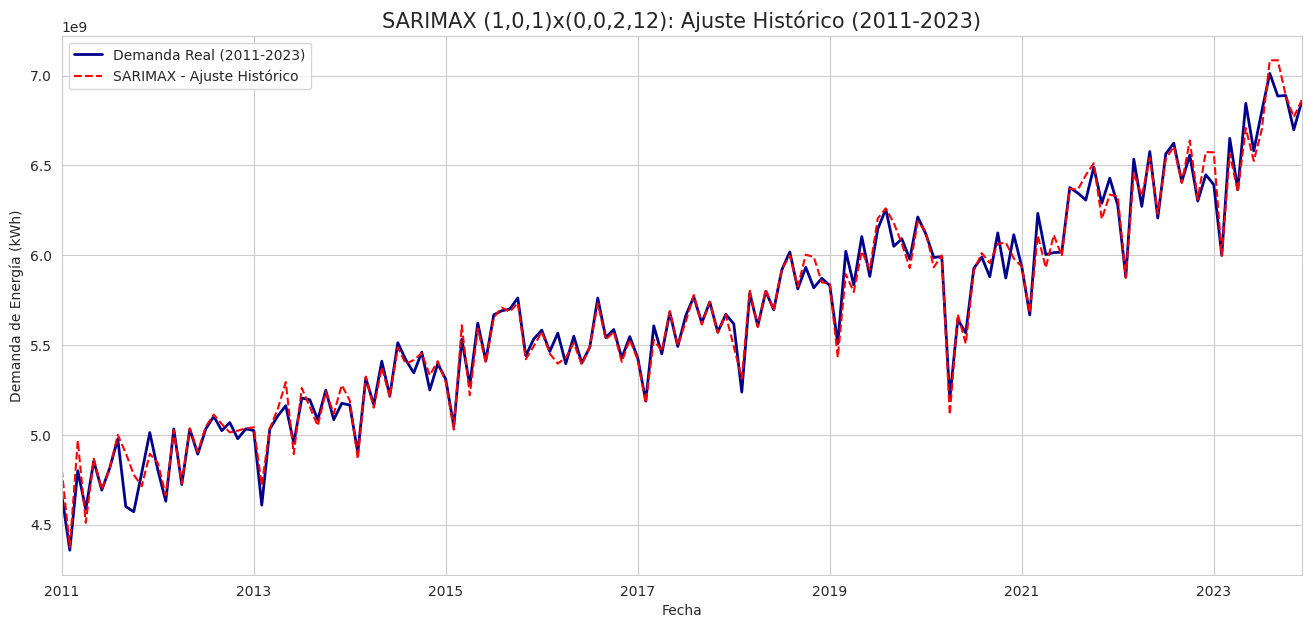

In [ ]:
import matplotlib.pyplot as plt

# Obtener los valores de ajuste (in-sample) de SARIMAX (ya reentrenado en todo y_full)
fitted_values_sarimax = final_sarimax_results.fittedvalues

plt.figure(figsize=(16, 7))
plt.title('SARIMAX (1,0,1)x(0,0,2,12): Ajuste Histórico (2011-2023)', fontsize=15)

# Trazar la Demanda Real
y_full.plot(label='Demanda Real (2011-2023)', color='darkblue', linewidth=2)

# Trazar el ajuste del modelo SARIMAX
fitted_values_sarimax.plot(label='SARIMAX - Ajuste Histórico', color='red', linestyle='--', linewidth=1.5)

plt.xlabel('Fecha')
plt.ylabel('Demanda de Energía (kWh)')
plt.legend()
plt.grid(True)
plt.show()

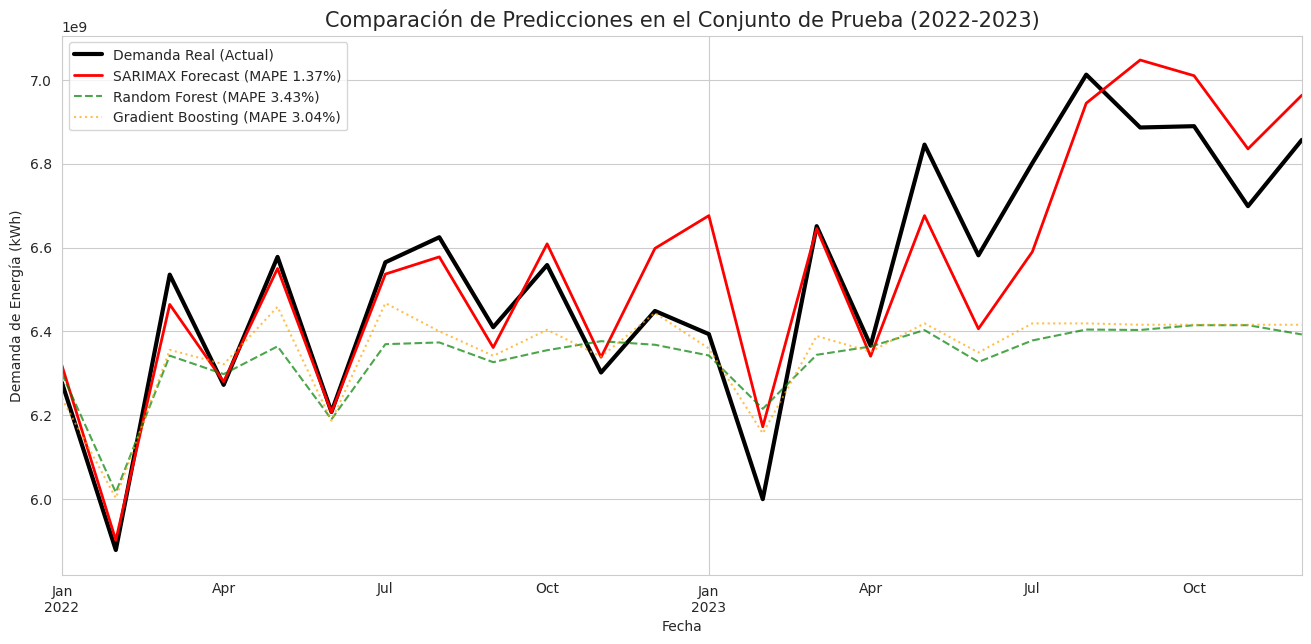

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Asumiendo que df_results, y_test existen del paso anterior
# df_results contiene 'Actual', 'SARIMAX_Forecast', 'RF_Forecast', 'GBR_Forecast'

plt.figure(figsize=(16, 7))
plt.title('Comparación de Predicciones en el Conjunto de Prueba (2022-2023)', fontsize=15)

# 1. Valores Reales
y_test.plot(label='Demanda Real (Actual)', color='black', linewidth=3)

# 2. SARIMAX (El Ganador)
df_results['SARIMAX_Forecast'].plot(label='SARIMAX Forecast (MAPE 1.37%)', color='red', linestyle='-', linewidth=2)

# 3. Random Forest
df_results['RF_Forecast'].plot(label='Random Forest (MAPE 3.43%)', color='green', linestyle='--', alpha=0.7)

# 4. Gradient Boosting
df_results['GBR_Forecast'].plot(label='Gradient Boosting (MAPE 3.04%)', color='orange', linestyle=':', alpha=0.7)

plt.xlabel('Fecha')
plt.ylabel('Demanda de Energía (kWh)')
plt.legend()
plt.grid(True)
plt.show()

1. Reentrenando el modelo SARIMAX (1,0,1)x(0,0,2,12) con todos los datos disponibles...
Reentrenamiento completado.

2. Features Futuras Creadas (Primeras 5 Filas):
            SumaPrecipitacion_mm  Generación_kWh  Demanda_No_Atendida_kWh
2024-01-01          76232.015891    7.019498e+09             4.581957e+06
2024-02-01          76232.015891    7.054596e+09             4.581957e+06
2024-03-01          76232.015891    7.089869e+09             4.581957e+06
2024-04-01          76232.015891    7.125318e+09             4.581957e+06
2024-05-01          76232.015891    7.160945e+09             4.581957e+06

3. Pronóstico generado exitosamente hasta 2030-12-01.


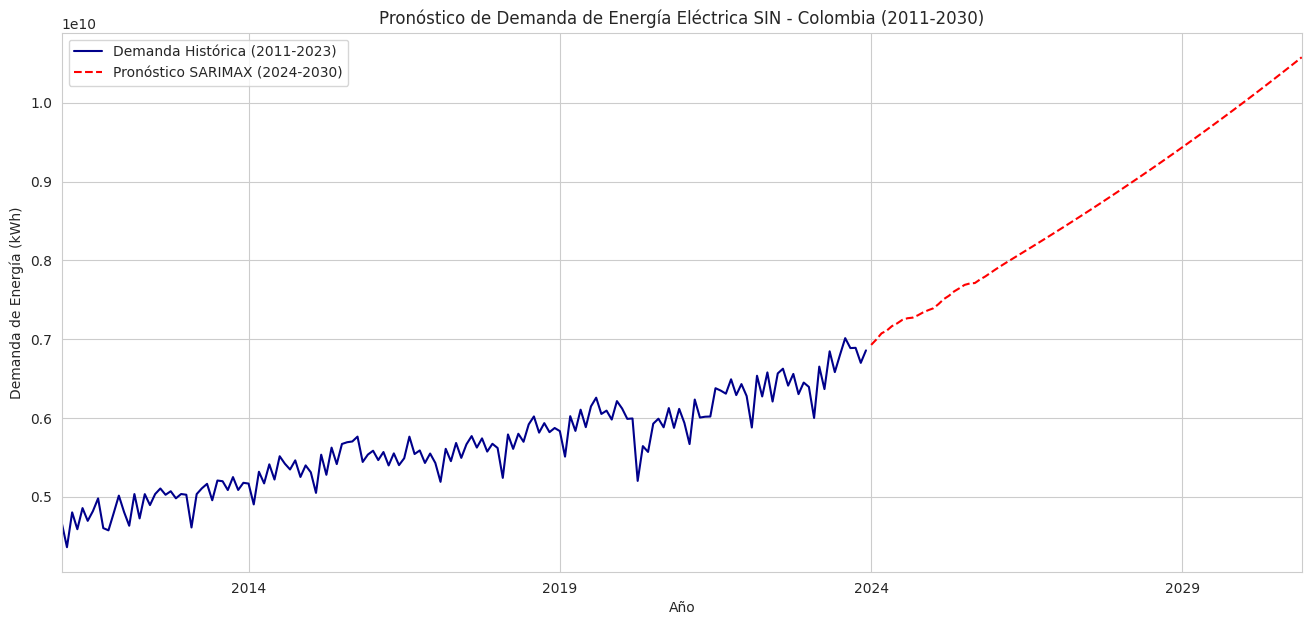


¡El proyecto de grado ha cumplido su objetivo! El pronóstico hasta 2030 ha sido generado con el mejor modelo.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Asumiendo la existencia y estructura de df_model de pasos anteriores ---
# Definiciones (para asegurar la consistencia)
target = 'Demanda_Energia_SIN_kWh'
FEATURES_SARIMAX = ['SumaPrecipitacion_mm', 'Generación_kWh', 'Demanda_No_Atendida_kWh']

y_full = df_model[target]
X_full = df_model[FEATURES_SARIMAX]

## 4.1. Reentrenamiento del Modelo Seleccionado

print("1. Reentrenando el modelo SARIMAX (1,0,1)x(0,0,2,12) con todos los datos disponibles...")

# Ajustar el modelo con los órdenes óptimos encontrados
final_sarimax_model = SARIMAX(
    y_full,
    exog=X_full,
    order=(1, 0, 1),
    seasonal_order=(0, 0, 2, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_sarimax_results = final_sarimax_model.fit(disp=False)
print("Reentrenamiento completado.")

## 4.2. Creación del DataFrame de Pronóstico (2024-2030)

# Crear el índice de fechas futuras
future_start_date = df_model.index.max() + pd.DateOffset(months=1)
future_end_date = '2030-12-01'
future_dates = pd.date_range(start=future_start_date, end=future_end_date, freq='MS')

# Crear el DataFrame futuro
df_future = pd.DataFrame(index=future_dates)
df_future['SumaPrecipitacion_mm'] = 0.0
df_future['Generación_kWh'] = 0.0
df_future['Demanda_No_Atendida_kWh'] = 0.0

# CRÍTICO: Rellenar las variables exógenas futuras (Estrategia Simplificada)
# Proyección de Generación_kWh (Asumiendo crecimiento de tendencia)
# Usaremos el último valor conocido para proyectar la tendencia
last_gen_value = df_model['Generación_kWh'].iloc[-1]
trend_factor = 1.005 # 0.5% de crecimiento mensual (ajustar si es necesario)
df_future['Generación_kWh'] = last_gen_value * (trend_factor ** np.arange(1, len(df_future) + 1))

# Proyección de Precipitación y Demanda No Atendida (Asumiendo media histórica)
df_future['SumaPrecipitacion_mm'] = df_model['SumaPrecipitacion_mm'].mean()
df_future['Demanda_No_Atendida_kWh'] = df_model['Demanda_No_Atendida_kWh'].mean()

print("\n2. Features Futuras Creadas (Primeras 5 Filas):")
print(df_future.head())

## 4.3. Generación del Pronóstico Final

# 3. Generar el pronóstico hasta 2030
forecast_2030 = final_sarimax_results.predict(
    start=future_dates.min(),
    end=future_dates.max(),
    exog=df_future[FEATURES_SARIMAX] # Usamos las features futuras proyectadas
)

# 4. Concatenar los datos históricos y el pronóstico para el gráfico
full_series = pd.concat([y_full, forecast_2030])

print("\n3. Pronóstico generado exitosamente hasta 2030-12-01.")


## 4.4. Visualización del Resultado Final

plt.figure(figsize=(16, 7))

# Trazar datos históricos (2011-2023)
y_full.plot(label='Demanda Histórica (2011-2023)', color='darkblue')

# Trazar el pronóstico (2024-2030)
forecast_2030.plot(label='Pronóstico SARIMAX (2024-2030)', color='red', linestyle='--')

# Opcional: Trazar el último año para ver la conexión
# y_full.iloc[-12:].plot(color='darkblue', linestyle='-')

plt.title('Pronóstico de Demanda de Energía Eléctrica SIN - Colombia (2011-2030)')
plt.xlabel('Año')
plt.ylabel('Demanda de Energía (kWh)')
plt.legend()
plt.grid(True)
plt.show()


print("\n¡El proyecto de grado ha cumplido su objetivo! El pronóstico hasta 2030 ha sido generado con el mejor modelo.")

In [ ]:
# --- Asumiendo la existencia y estructura de df_future de pasos anteriores ---
# Solo seleccionamos las variables optimizadas del DataFrame futuro
X_future_optimizado = df_future[FEATURES_SARIMAX_OPTIMO]

In [ ]:
import matplotlib.pyplot as plt

print("\n2. Generando pronóstico a 2030 con Intervalos de Confianza (IC 95%)...")

# Generar el pronóstico y el IC para 84 períodos
forecast_results = final_sarimax_results_optimizado.get_forecast(
    steps=len(X_future_optimizado),
    exog=X_future_optimizado
)

# Extraer el pronóstico puntual y el IC
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int(alpha=0.05) # IC del 95%

# 3. Concatenar los datos históricos y el pronóstico para el gráfico
y_full_forecast = pd.concat([y_full, forecast_mean])

print("Pronóstico con IC generado exitosamente.")


2. Generando pronóstico a 2030 con Intervalos de Confianza (IC 95%)...
Pronóstico con IC generado exitosamente.


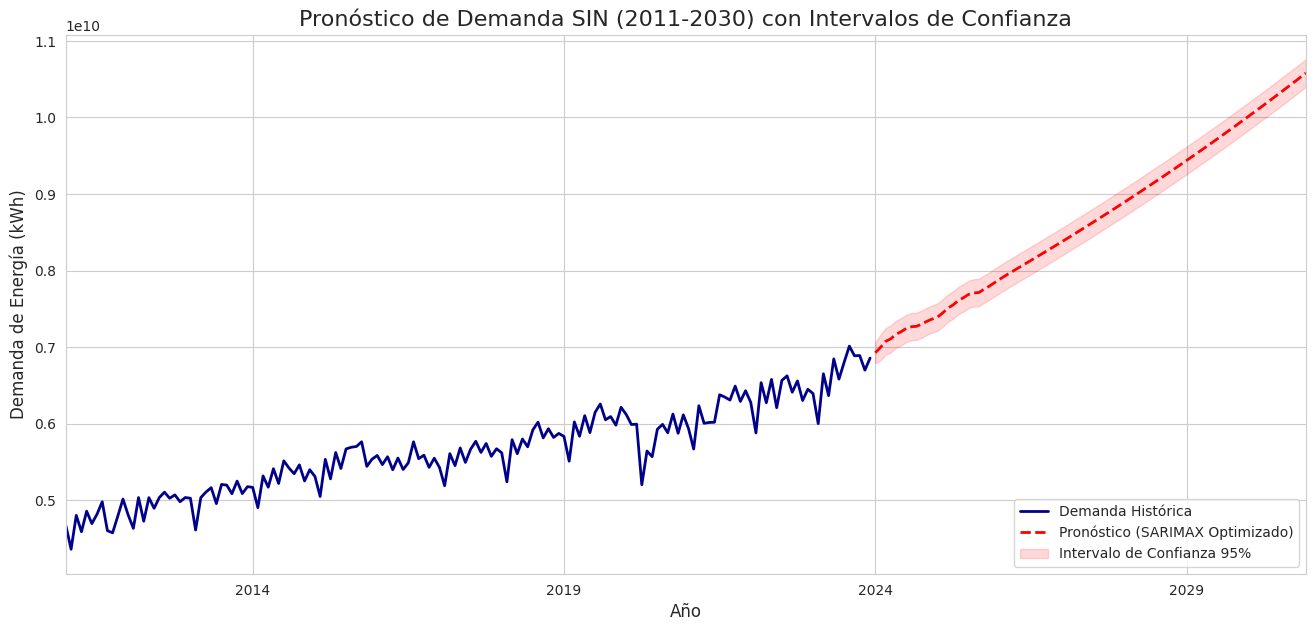

In [ ]:
plt.figure(figsize=(16, 7))
plt.title('Pronóstico de Demanda SIN (2011-2030) con Intervalos de Confianza', fontsize=16)

# Trazar datos históricos (2011-2023)
y_full.plot(label='Demanda Histórica', color='darkblue', linewidth=2)

# Trazar el pronóstico puntual
forecast_mean.plot(label='Pronóstico (SARIMAX Optimizado)', color='red', linestyle='--', linewidth=2)

# Trazar el Intervalo de Confianza (relleno sombreado)
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='red', alpha=0.15, label='Intervalo de Confianza 95%'
)

plt.xlabel('Año', fontsize=12)
plt.ylabel('Demanda de Energía (kWh)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()